This demonstration will show how to reproject the NEMO velocities for plotting.

NEMO velocities are usually calculated and saved in along grid i and j directions. This causes an issue when plotting velocities as vectors on a map where it is assumed that i and j velocities point eastwards and northwards but the grid is curvilinear.

There are additonal isses when plotting quivers over the poles that we will cover.

The data we use here comes from a global model that has been cropped to the Arctic region. For Arctic contour plotting see example_scripts/configuration_gallery/gc31_arctic_example_plot.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import coast


c:\Users\benbar\AppData\Local\anaconda3\envs\coast\lib\site-packages\utide\harmonics.py:16: RuntimeWarning: invalid value encountered in cast
  nshallow = np.ma.masked_invalid(const.nshallow).astype(int)
c:\Users\benbar\AppData\Local\anaconda3\envs\coast\lib\site-packages\utide\harmonics.py:17: RuntimeWarning: invalid value encountered in cast
  ishallow = np.ma.masked_invalid(const.ishallow).astype(int) - 1


### Usage of coast._utils.plot_util.velocity_grid_to_geo()

Plotting velocities with curvilinear grid and/or on a polar stereographic projection.

In [2]:
root = "../../../../"
# Paths to a single or multiple data files.
dn_files = root + "example_files/"
fn_nemo_dat_t = dn_files + "HadGEM3-GC31-HH_hist_thetao.nc"
fn_nemo_dat_u = dn_files + "HadGEM3-GC31-HH_hist_uo.nc"
fn_nemo_dat_v = dn_files + "HadGEM3-GC31-HH_hist_vo.nc"
fn_nemo_config_t = root + "config/gc31_nemo_grid_t.json"
fn_nemo_config_u = root + "config/gc31_nemo_grid_u.json"
fn_nemo_config_v = root + "config/gc31_nemo_grid_v.json"

# Set path for domain file if required.
fn_nemo_dom = dn_files + "gc31_domain.nc"

# Define output filepath (optional: None or str)
fn_out = './quiver_plot.png'

# Read in multiyear data (This example uses NEMO data from a single file.)
nemo_data_t = coast.Gridded(fn_data=fn_nemo_dat_t,
                          fn_domain=fn_nemo_dom,
                          config=fn_nemo_config_t,
                          ).dataset
nemo_data_u = coast.Gridded(fn_data=fn_nemo_dat_u,
                          fn_domain=fn_nemo_dom,
                          config=fn_nemo_config_u,
                          ).dataset
nemo_data_v = coast.Gridded(fn_data=fn_nemo_dat_v,
                          fn_domain=fn_nemo_dom,
                          config=fn_nemo_config_v,
                          ).dataset

Select surface u and v as an example:

In [3]:
# Coarsen the data to make it run faster, also we don't need to plot the full resolution for such a wide area.
nemo_data_uc = nemo_data_u.coarsen(y_dim=10, x_dim=10).mean()
nemo_data_vc = nemo_data_v.coarsen(y_dim=10, x_dim=10).mean()
nemo_data_tc = nemo_data_t.coarsen(y_dim=10, x_dim=10).mean()

# Select specific data variables.
data_u = nemo_data_uc[["u_velocity"]]
data_v = nemo_data_vc[["v_velocity"]]

# Select one time step and surface currents
data_u = data_u.isel(t_dim=0, z_dim=0)
data_v = data_v.isel(t_dim=0, z_dim=0)

# Calculate speed
speed = ((data_u.to_array().values[0, :, :] ** 2 + data_v.to_array().values[0, :, :] ** 2) ** 0.5)

# Calculate adjustment for the curvilinear grid
u_new, v_new = coast._utils.plot_util.velocity_grid_to_geo(
        nemo_data_tc.longitude.values, nemo_data_tc.latitude.values, 
        data_u.to_array().values[0, :, :], data_v.to_array().values[0, :, :], polar_stereo=False)


0.0 %
1.694915254237288 %
3.389830508474576 %
5.084745762711865 %
6.779661016949152 %
8.47457627118644 %
10.16949152542373 %
11.864406779661017 %
13.559322033898304 %
15.254237288135593 %
16.94915254237288 %
18.64406779661017 %
20.33898305084746 %
22.033898305084744 %
23.728813559322035 %
25.423728813559322 %
27.11864406779661 %
28.8135593220339 %
30.508474576271187 %
32.20338983050847 %
33.89830508474576 %
35.59322033898305 %
37.28813559322034 %
38.983050847457626 %
40.67796610169492 %
42.3728813559322 %
44.06779661016949 %
45.76271186440678 %
47.45762711864407 %
49.152542372881356 %
50.847457627118644 %
52.54237288135594 %
54.23728813559322 %
55.932203389830505 %
57.6271186440678 %
59.32203389830508 %
61.016949152542374 %
62.71186440677966 %
64.40677966101694 %
66.10169491525424 %
67.79661016949152 %
69.49152542372882 %
71.1864406779661 %
72.88135593220339 %
74.57627118644068 %
76.27118644067797 %
77.96610169491525 %
79.66101694915254 %
81.35593220338984 %
83.05084745762711 %
84.7457

In [4]:
# Apply the CartoPy steroegraphic polar correction
# NOTE: This coul have been applied automatically with the, polar_stereo=True in 
# coast._utils.plot_util.velocity_grid_to_geo()

u_pol, v_pol = coast._utils.plot_util.velocity_polar(u_new, v_new, nemo_data_tc.latitude.values)

In [5]:
# Set things up for plotting North Pole stereographic projection

# Data projection
data_crs = ccrs.PlateCarree()
# Plot projection
mrc = ccrs.NorthPolarStereo(central_longitude=0.0)

Below shows the u and v velocities when plotted with and without adjustment.

The plot shows three cases: 1:no correction, 2:the NEMO grid correction, and 3:the NEMO grid correction with polar sterographic plot correction. We also plot the final corrected u and v velocities as streamlines.
- In case 1, the lowere latutude velocities aren't too bad but become irregular further north as the grid lines deviate form lat and lon.
- In case 2, the irrigulary still persits even with the grid correction. This is the result of a CartPy bug which also worsens at high latitudes.
- In case 3, both corrections have been applied and the velocites quivers now align with the route of strong current speed as would be expected.

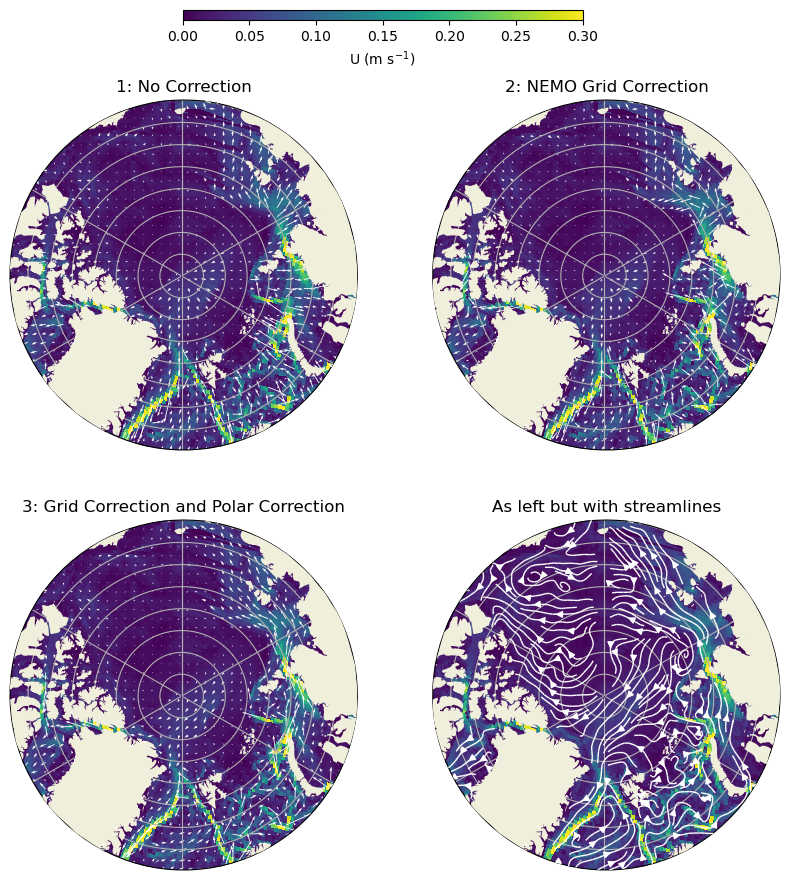

In [6]:
# Subplot axes settings
n_r = 2  # Number of subplot rows
n_c = 2  # Number of subplot columns
figsize = (10, 10)  # Figure size
subplot_padding = 0.5  # Amount of vertical and horizontal padding between plots
fig_pad = (0.075, 0.075, 0.1, 0.1)  # Figure padding (left, top, right, bottom)

# Labels and Titles
fig_title = "Velocity Plot"  # Whole figure title

# Create plot and flatten axis array
fig, ax = plt.subplots(n_r, n_c, subplot_kw={"projection": mrc}, sharey=True, sharex=True, figsize=figsize)
cax = fig.add_axes([0.3, 0.96, 0.4, 0.01])


ax = ax.flatten()
for rr in range(n_r * n_c):
    ax[rr].add_feature(cfeature.LAND, zorder=100)
    ax[rr].gridlines()
    ax[rr].set_extent([-180, 180, 70, 90], crs=data_crs)
    coast._utils.plot_util.set_circle(ax[rr])


cs = ax[0].pcolormesh(nemo_data_tc.longitude.values, nemo_data_tc.latitude.values, speed, transform=data_crs, vmin=0, vmax=0.3)
ax[0].quiver(nemo_data_tc.longitude.values, nemo_data_tc.latitude.values, 
    data_u.to_array().values[0, :, :], data_v.to_array().values[0, :, :], 
    color='w', transform=data_crs, angles='xy', regrid_shape=40)

ax[1].pcolormesh(nemo_data_tc.longitude.values, nemo_data_tc.latitude.values, speed, transform=data_crs, vmin=0, vmax=0.3)
ax[1].quiver(nemo_data_tc.longitude.values, nemo_data_tc.latitude.values, 
    u_new, v_new, 
    color='w', transform=data_crs, angles='xy', regrid_shape=40)

ax[2].pcolormesh(nemo_data_tc.longitude.values, nemo_data_tc.latitude.values, speed, transform=data_crs, vmin=0, vmax=0.3)
ax[2].quiver(nemo_data_tc.longitude.values, nemo_data_tc.latitude.values, 
    u_pol, v_pol, 
    color='w', transform=data_crs, angles='xy', regrid_shape=40)

ax[3].pcolormesh(nemo_data_tc.longitude.values, nemo_data_tc.latitude.values, speed, transform=data_crs, vmin=0, vmax=0.3)
ax[3].streamplot(nemo_data_tc.longitude.values, nemo_data_tc.latitude.values, 
    u_pol, v_pol, transform=data_crs, linewidth=1, density=2, color='w', zorder=101)

ax[0].set_title('1: No Correction')
ax[1].set_title('2: NEMO Grid Correction')
ax[2].set_title('3: Grid Correction and Polar Correction')
ax[3].set_title('As left but with streamlines')

fig.colorbar(cs, cax=cax, orientation='horizontal')
cax.set_xlabel('U (m s$^{-1}$)')

#fig.tight_layout(w_pad=subplot_padding, h_pad=subplot_padding)
#fig.subplots_adjust(left=(fig_pad[0]), bottom=(fig_pad[1]), right=(1 - fig_pad[2]), top=(1 - fig_pad[3]))

plt.show()
fig.savefig(fn_out)